In [2]:
import pandas as pd
import numpy as np

tasks = ('cleanHouse', 'fourCorners', 'harvester', 'randomMaze', 'stairClimber', 'topOff')

df = {}
grouped_data = {}
for task in tasks:
    df[task] = pd.read_csv(f'dt-{task}.csv')

    # Group data by 'iteration' and 'reward'
    grouped_data[task] = df[task].groupby('iteration')['reward'].apply(list)

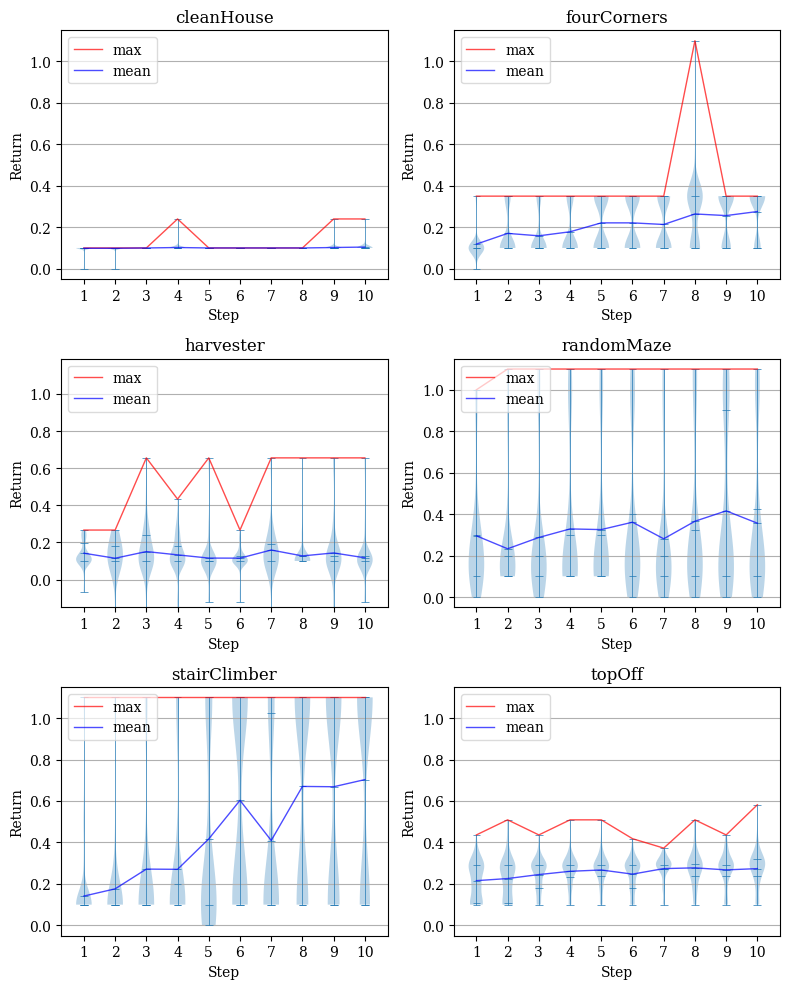

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

for ax, task in zip(axes.flatten(), tasks):
    # violin plot
    parts = ax.violinplot(grouped_data[task].values, showmeans=True, quantiles=[[0.25, 0.75]] * len(grouped_data[task]))
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans', 'cquantiles'):
        vp = parts[partname]
        vp.set_linewidth(0.5)

    # highlight max return
    max_line = ax.plot(grouped_data[task].index, grouped_data[task].apply(max), color='red', alpha=0.7, label="max", linewidth=1)
    mean_line = ax.plot(grouped_data[task].index, grouped_data[task].apply(np.mean), color='blue', alpha=0.7, label="mean", linewidth=1)
    # for iteration in grouped_data[task].index:
    #     ax.scatter(iteration, max(grouped_data[task][iteration]), s=8, color='red', alpha=0.7)

    # Customize the plot
    ax.set_title(task)
    ax.set_xlabel('Step')
    ax.set_ylabel('Return')
    ax.set_xticks(grouped_data[task].index)
    ax.set_xticklabels(grouped_data[task].index)  # Set iteration numbers as x-axis labels
    ax.set_ylim([-0.15, 1.19]) if task == 'harvester' else ax.set_ylim([-0.05, 1.15])
    ax.legend(loc='upper left', framealpha=0.7)
    ax.grid(visible=True, axis='y', zorder=0)

plt.tight_layout()

# Save and display the plot
plt.savefig('dt_train_violin.pdf')  # Save the plot as a PDF file
plt.show()


In [3]:
grouped_data['cleanHouse']
max_values = grouped_data['cleanHouse'].apply(max)
print(max_values)


iteration
1     0.10
2     0.10
3     0.10
4     0.24
5     0.10
6     0.10
7     0.10
8     0.10
9     0.24
10    0.24
Name: reward, dtype: float64


## Number of unique programs explored

In [4]:
for task in tasks:
    unique_progs = df[task]['program'][df[task]['iteration'] == 10].unique()
    print(task, len(unique_progs))

cleanHouse 59
fourCorners 55
harvester 28
randomMaze 63
stairClimber 49
topOff 63


## Max reward programs

In [7]:
for task in tasks:
    max_reward_prog = df[task][df[task]['iteration'] == 10].groupby('program')['reward'].apply(np.maximum.reduce)
    print(task, max_reward_prog.idxmax(), max_reward_prog.max())

cleanHouse DEF run m( move turnRight move WHILE c( leftIsClear c) w( pickMarker move w) m) 0.2400000095367431
fourCorners DEF run m( IF c( frontIsClear c) i( WHILE c( frontIsClear c) w( move w) i) putMarker m) 0.3499999940395355
harvester DEF run m( WHILE c( leftIsClear c) w( move move pickMarker turnRight w) m) 0.6555556058883667
randomMaze DEF run m( REPEAT R=4 r( turnRight turnLeft r) WHILE c( noMarkersPresent c) w( move turnRight w) m) 1.100000023841858
stairClimber DEF run m( IF c( leftIsClear c) i( WHILE c( not c( markersPresent c) c) w( turnRight move w) i) m) 1.100000023841858
topOff DEF run m( WHILE c( leftIsClear c) w( IFELSE c( markersPresent c) i( putMarker move i) ELSE e( move move e) w) m) 0.581818163394928


## Analyze Variation with `pct_traj`

Analyze the variation in performance (max reward) of the decision transformer with variance in `pct_traj` parameter. Essentially, how robust is the decision transformer to low quality trajectories?

_Note: data is from the `topOff` task_

In [2]:
import pandas as pd
import numpy as np

values = ('001', '01', '05', '10')

df = {}
grouped_data = {}

for value in values:
    df[value] = pd.read_csv(f'pct_{value}.csv')

    # Group data by 'iteration' and 'reward'
    grouped_data[value] = df[value].groupby('iteration')['reward'].apply(list)

### Plot the line graph of max reward vs. steps for each `pct_traj` value

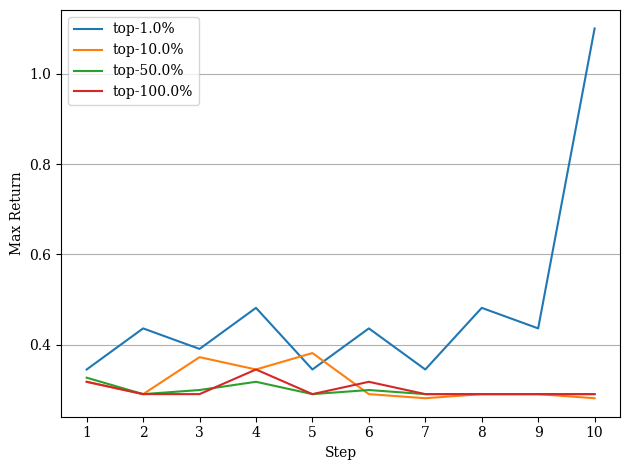

In [7]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

for value in values:
    plt.plot(grouped_data[value].index, grouped_data[value].apply(max), label=f'top-{float(value[0] + "." + value[1:]) * 100}%')

plt.xticks(grouped_data['001'].index, grouped_data['001'].index)
plt.legend(loc='upper left', framealpha=0.7)
plt.grid(visible=True, axis='y', zorder=0)

plt.xlabel('Step')
plt.ylabel('Max Return')
plt.legend()

plt.tight_layout()

# Save and display the plot
plt.savefig('dt_pct_traj.pdf')  # Save the plot as a PDF file
plt.show()


## Analyze similarity of DT programs to training dataset

Sample 1000 programs from the decision transformer and count how many are present in the training dataset. This gives an idea of how much the DT is simply regurgitating data vs. producing novel programs.

_Note: data is from the `topOff` task_

In [57]:
import pandas as pd

df = pd.read_csv('rollouts_1000.csv')
final = df[df['iteration'] == 10].drop_duplicates(subset=['program'])

train = pd.read_csv('../leaps/leaps_data.csv')
percentile = 99
threshold = train['topOff_reward'].quantile(percentile / 100)
best = train[train['topOff_reward'] >= threshold].drop_duplicates(subset=['program'])

In [58]:
print(threshold, len(best), len(final))

0.2909091114997864 6219 758


Why were only 998 programs samples and not 1000?

In [60]:
print(final['program'].nunique(), best['program'].nunique())

758 6219


In [61]:
mask = final['program'].isin(best['program'])
in_train = final[mask]
num_present = len(in_train)
print(num_present, num_present / final['program'].nunique() * 100)

115 15.171503957783642


There are 115 programs from the sampled programs that are present in the training dataset, which is ~15% of the sampled programs.

What's the distribution of reward for the sampled programs that are present in the training dataset vs. those that are not?

In [62]:
novel = final[~mask]

Plot the graph of reward distribution as a box plot for the two sets of programs.

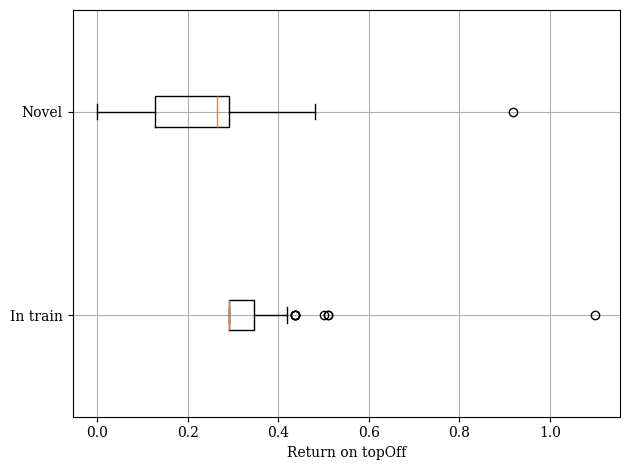

In [63]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

positions = [1, 2]
plt.boxplot([in_train['reward'], novel['reward']], positions=positions, vert=False)
plt.yticks(positions, ['In train', 'Novel'])
plt.xlabel('Return on topOff')

plt.grid(visible=True, axis='both', zorder=0)
plt.tight_layout()
plt.savefig('dt_similarity.pdf')
plt.show()

Test whether there is a statistical significance in the difference in reward distribution between the two sets of programs.

In [66]:
from scipy import stats

print(f'Sample sizes: in_train={len(in_train)}, novel={len(novel)}')
print(f'Sample variances: in_train={in_train["reward"].var()}, novel={novel["reward"].var()}')

t_statistic, p_value = stats.ttest_ind(in_train['reward'], novel['reward'], equal_var=False, alternative='greater') # Welch's t-test
print(t_statistic, p_value)

Sample sizes: in_train=115, novel=643
Sample variances: in_train=0.00773629303001403, novel=0.008993051579788509
11.226023890036798 1.0


There is a significant difference in the reward distribution between the two sets of programs. The programs that are present in the training dataset have a higher median reward than those that are not present in the training dataset.